# CNN Module_1_sliced_5sec

## Imports

In [1]:
import librosa
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import multilabel_confusion_matrix, classification_report

## Extract the spectrogram of .wav files

In [ ]:
def extract_mel_spectrogram(file_path):
    y, sr = librosa.load(file_path, sr=None, duration=5.0)  # Limit to 5 seconds to keep data consistent
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to decibels for better visualization
    return mel_spec_db

## Extract features / create training data

In [ ]:
data = pd.read_csv('preprocessed_data/preprocessed_data_sliced.csv') #change the path, if needed


unique_instruments = [1, 41, 42, 43, 61, 71, 72]

if isinstance(data['target'].iloc[0], str):
    data['target'] = data['target'].apply(eval)

mlb = MultiLabelBinarizer(classes=unique_instruments)

# # Apply MultiLabelBinarizer to the 'target' column to get the binary representation

X = []  # Features (Mel-spectrograms)
y = []  # Targets (binary labels)

for _, entry in data.iterrows():
    mel_spec = extract_mel_spectrogram(entry["filename"])
    X.append(mel_spec)

    # Use MultiLabelBinarizer to encode the target (list of instruments)
    encoded_target = mlb.fit_transform([entry["target"]])  # entry['target'] contains a list of instruments
    y.append(encoded_target[0])


# Pad the Mel-spectrograms to make them have the same shape (for CNN input)
X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post', dtype='float32', value=0)

# Add the channel dimension to X (since it is a grayscale image, the channel will be 1)
X = np.expand_dims(X, axis=-1)  # Shape will be (batch_size, height, width, 1)

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/Users/andregusmao/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) [69, 74] will be ignored
  warnings.warn(
/Users/andregusmao/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) [74] will be ignored
  warnings.warn(
/Users/andregusmao/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) [69] will be ignored
  warnings.warn(
/Users/andregusmao/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) [7] will be ignored
  warnings.warn(
/Users/andregusmao/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) [44] will be ignored
  warnings.warn(
/Users/andregusmao/.pyenv/versions/3.10.6/envs/

## Create / evaluate CNN model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import models, layers

def create_cnn_model(shape, num_classes):
    model = models.Sequential([
        layers.InputLayer(input_shape=shape),
        layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'recall', 'precision'])

    return model

input_shape = X_train.shape[1:]  # (height, width, channels), usually (time_steps, freq_bins, 1)
num_classes = y_train.shape[1]  # Number of instruments (output dimensions)


model = create_cnn_model(input_shape, num_classes)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


history = model.fit(
    X_train, y_train,
    epochs=400,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

results = model.evaluate(X_test, y_test)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")
print(f"Test Precision: {results[2]:.4f}")
print(f"Test Recall: {results[3]:.4f}")

/Users/andregusmao/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/400
606/606 ━━━━━━━━━━━━━━━━━━━━ 96s 157ms/step - accuracy: 0.7230 - loss: 0.3300 - precision: 0.8071 - recall: 0.7645 - val_accuracy: 0.2763 - val_loss: 1.3736 - val_precision: 0.5256 - val_recall: 0.4525
Epoch 2/400
606/606 ━━━━━━━━━━━━━━━━━━━━ 94s 156ms/step - accuracy: 0.7624 - loss: 0.1113 - precision: 0.9263 - recall: 0.9179 - val_accuracy: 0.6629 - val_loss: 2.1810 - val_precision: 0.6649 - val_recall: 0.3543
Epoch 3/400
606/606 ━━━━━━━━━━━━━━━━━━━━ 95s 156ms/step - accuracy: 0.7716 - loss: 0.0727 - precision: 0.9496 - recall: 0.9514 - val_accuracy: 0.7264 - val_loss: 1.8678 - val_precision: 0.7552 - val_recall: 0.4079
Epoch 4/400
606/606 ━━━━━━━━━━━━━━━━━━━━ 94s 156ms/step - accuracy: 0.7743 - loss: 0.0536 - precision: 0.9637 - recall: 0.9640 - val_accuracy: 0.7398 - val_loss: 0.7224 - val_precision: 0.8380 - val_recall: 0.5803
Epoch 5/400
606/606 ━━━━━━━━━━━━━━━━━━━━ 94s 155ms/step - accuracy: 0.7388 - loss: 0.0422 - precision: 0.9700 - recall: 0.9745 - val_accuracy: 0

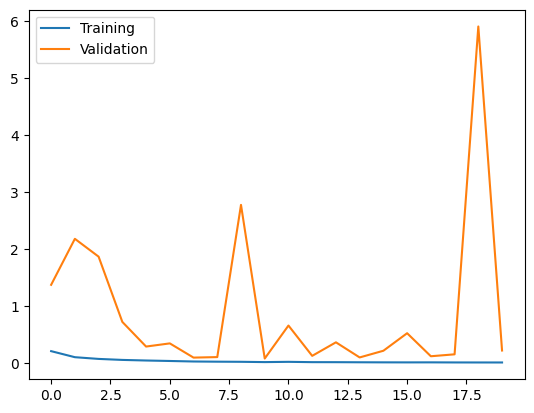

In [5]:
plt.plot(history.history['loss'], label = 'Training')
plt.plot(history.history['val_loss'], label = 'Validation')
plt.legend()
plt.show()

## Prediction / Confusion matrix

In [ ]:
def predict_instruments(file_path, model, mlb):

    mel_spec = extract_mel_spectrogram(file_path)

    mel_spec = np.expand_dims(mel_spec, axis=-1)
    mel_spec = tf.keras.preprocessing.sequence.pad_sequences([mel_spec], padding='post', dtype='float32', value=0)

    prediction = model.predict(mel_spec)

    predicted_instruments = mlb.inverse_transform((prediction > 0.5).astype(int))  # Threshold at 0.5 for multi-label
    return predicted_instruments[0]

new_file_path = '/Users/andregusmao/Documents/Le Wagon/Project/test_data/3333.wav'
predicted_instruments = predict_instruments(new_file_path, model, mlb)

print(f"Predicted instruments for '{new_file_path}': {predicted_instruments}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted instruments for '/Users/andregusmao/Documents/Le Wagon/Project/test_data/3333.wav': (41, 42, 43)


In [ ]:
# Directory containing test .wav files
wav_dir = 'test_data'

# Ground truth labels corresponding to each file
# This is a dictionary where the key is the file name, and the value is the true label
# For multi-label classification, use a binary array for each label
ground_truth = {
    '1759.wav': [1],
    '1819.wav': [61, 71, 72],
    '2106.wav': [41, 42, 43],
    '2191.wav': [41],
    '2298.wav': [43],
    '2303.wav': [1],
    '2382.wav': [41, 42, 43],
    '2416.wav': [61, 71, 72],
    '2556.wav': [1],
    '2628.wav': [1, 41],

}

# Flatten all unique labels to determine the full set of classes
all_classes = sorted({label for labels in ground_truth.values() for label in labels})

mlb = MultiLabelBinarizer(classes=all_classes)
mlb.fit([all_classes])  # Fit the binarizer

y_true = []
y_pred = []

for file_name in os.listdir(wav_dir):
    if file_name.endswith('.wav') and file_name in ground_truth:
        file_path = os.path.join(wav_dir, file_name)

        predicted_instruments = predict_instruments(file_path, model, mlb)

        y_true.append(mlb.transform([ground_truth[file_name]])[0])
        y_pred.append(mlb.transform([predicted_instruments])[0])

y_true = np.array(y_true)
y_pred = np.array(y_pred)

mcm = multilabel_confusion_matrix(y_true, y_pred)

for i, (label, cm) in enumerate(zip(mlb.classes_, mcm)):
    print(f"Confusion Matrix for class {label}:\n{cm}")

report = classification_report(y_true, y_pred, target_names=[str(label) for label in mlb.classes_])
print("\nClassification Report:\n")
print(report)

# # Plot confusion matrix for each class
# for i, (label, cm) in enumerate(zip(mlb.classes_, mcm)):
#     plt.figure(figsize=(6, 4))
#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not "+str(label), str(label)], yticklabels=["Not "+str(label), str(label)])
#     plt.title(f"Confusion Matrix for Class {label}")
#     plt.xlabel("Predicted")
#     plt.ylabel("Actual")
#     plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Confusion Matrix for class 1:
[[6 0]
 [0 4]]
Confusion Matrix for class 41:
[[6 0]
 [0 4]]
Confusion Matrix for class 42:
[[8 0]
 [0 2]]
Confusion Matrix for class 43:
[[7 0]
 [0 3]]
Confusion Matrix for class 61:
[[8 0]
 [0 2]]
Confusion Matrix for class 71:
[[8 0]
 [0 2]]
Confusion Matrix for class 72:
[[8 0]
 [0 2]]

Classification Report:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         4
          41       1.00      1.00      1.00         4
          42       1.00      1.00      1.00         2
          43       1.00      1.00      1.00         3
   

## Save the model

In [15]:
ls CNN_model1_sliced2

ls: CNN_model1_sliced2: No such file or directory


In [16]:
# Save the model in TensorFlow's SavedModel format
model.save('Models/CNN_model1_sliced2.keras')

## Load saved the model

In [17]:
from tensorflow.keras.models import load_model

# Load the .keras file
saved_model = load_model('Models/CNN_model1_sliced2.keras')

In [18]:
# Example: Predict instruments in a new audio file
new_file_path = '/Users/andregusmao/Documents/Le Wagon/Project/test_data/1819.wav'
predicted_instruments = predict_instruments(new_file_path, saved_model, mlb)
print(f"Predicted instruments for '{new_file_path}': {predicted_instruments}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Predicted instruments for '/Users/andregusmao/Documents/Le Wagon/Project/test_data/1819.wav': (61, 71, 72)


In [1]:
!pip freeze > requirements.txt

In [ ]:

INSTRUMENT_MAP = {
    1: 'Piano',
    41: 'Violin',
    42: 'Viola',
    43: 'Cello',
    61: 'Horn',
    71: 'Bassoon',
    72: 'Clarinet',
}
# Function to predict instruments from a new .wav file
def predict_instruments(file_path, model, mlb):
    # Extract Mel-spectrogram from the input file
    mel_spec = extract_mel_spectrogram(file_path)
    # Pad or reshape the spectrogram to match the model input shape
    mel_spec = np.expand_dims(mel_spec, axis=-1)  # Add channel dimension
    mel_spec = tf.keras.preprocessing.sequence.pad_sequences([mel_spec],
                                                             padding="post",
                                                             dtype="float32",
                                                             value=0)
    prediction = model.predict(mel_spec)[0]
    # Get the instrument labels
    instrument_labels = mlb.classes_
    results = []
    for label, prob in zip(instrument_labels, prediction):
        if int(label) in INSTRUMENT_MAP:
            results.append((INSTRUMENT_MAP[int(label)], prob))
    # Sort results by probability in descending order
    results.sort(key=lambda x: x[1], reverse=True)
    return results

new_file_path = "./test_data/2191.wav"

predicted_instruments = predict_instruments(new_file_path, saved_model, mlb)
print(f"Predicted instruments for {new_file_path}:")
for instrument, probability in predicted_instruments:
    print(f"{instrument}: {probability:.2%}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted instruments for ./test_data/2191.wav:
Violin: 100.00%
Viola: 11.08%
Cello: 2.89%
Piano: 0.00%
Horn: 0.00%
Bassoon: 0.00%
Clarinet: 0.00%
